There are 17 total training examples.


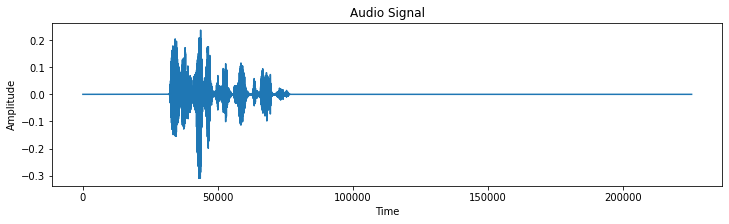

**Shape of Audio Signal** : (225440,)

**Transcript** : pull this lever to activate the piston

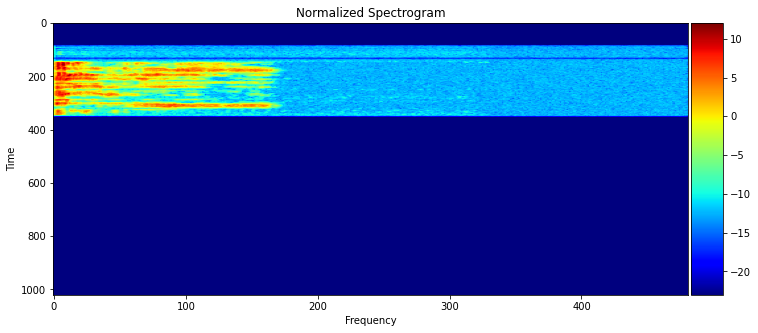

**Shape of Spectrogram** : (1021, 481)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 481)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, None, 512)         1526784   
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 512)         2048      
_________________________________________________________________
activation_1 (Activation)    (None, None, 512)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
gru_2 (GRU)                  (None, None, 512)         1574400   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 512)         0   

In [14]:
import json
import numpy as np
import random
import librosa
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.lib.stride_tricks import as_strided
from scipy import signal
from tqdm import tqdm
import scipy.io.wavfile as wavfile
from scipy.io.wavfile import read
from scipy.io.wavfile import read as read_wav
import IPython.display as ipd
import os
import argparse
import time
import time , csv 
import _pickle as pickle
from keras import backend as K
from keras.models import Model
from keras.optimizers import SGD, RMSprop , Adam
from keras.callbacks import ModelCheckpoint 
from keras.layers import (BatchNormalization, Conv1D, Dense, Input, 
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM, Lambda , Dropout)

!pip install pydub

import pandas as pd
from pydub import AudioSegment
from pydub.playback import play
import io


df = pd.read_csv('/content/drive/My Drive/datasets_5793_9812_cv-other-test.csv')
dataset = df['text']
files = '/content/drive/My Drive/another_test/'
sorted_files = sorted(files)
data ,durations_list , texts_list =  [] , [] , []

for i  in range(17):
  texts_list.append(dataset[i])

for file in os.listdir('/content/drive/My Drive/another_test/'):
  data.append( '/content/drive/My Drive/another_test/' + file ) 

data = sorted(data)

for i in range(17):
  durations_list.append(librosa.get_duration(filename= data[i]))

char_map = {"'":0,'<SPACE>':1,'a':2,'b':3,'c':4,'d':5,'e':6,'f':7,'g':8,'h':9,'i':10,'j':11,'k':12,'l':13,'m':14,'n':15,'o':16,'p':17,'q':18,'r':19,'s':20,'t':21,'u':22,'v':23,'w':24,'x':25,"y":26,'z':27,' ':28}
index_map = { char_map[key]:key for key in char_map}

def text_to_sequence(text):
    """ Convert text to an integer sequence """
    int_sequence = []
    for c in text:
        if c == ' ':
            ch = char_map['<SPACE>']
        else:
            ch = char_map[c]
        int_sequence.append(ch)
    return int_sequence

def sequence_to_text(int_sequence):
    """ Convert an integer sequence to text """
    text = []
    for c in int_sequence:
        ch = index_map[c]
        text.append(ch)
    return text

def spectrogram_from_file(wav_file):
    rate, data = wavfile.read(wav_file)
    nperseg = int(round(20 * rate / 1e3))
    noverlap = int(round(10 * rate / 1e3))

    _, _, spec = signal.spectrogram(data, fs=rate,
                                    window='hann', nperseg=nperseg, noverlap=noverlap,
                                    detrend=False)

    return np.log(spec.T.astype(np.float32) + 1e-10)


class audiogenerator():
  def __init__(self , step=10 , window=20 , max_freq = 8000 , minibatch_size=17 , spectrogram=True , max_duration=10.0 ):
    self.feat_dim = 481
    self.step = step
    self.window = window
    self.max_freq = max_freq
    self.cur_train_index = 0
    self.max_duration = max_duration
    self.minibatch_size = minibatch_size
    self.spectrogram = spectrogram

  def get_batch(self , partition):
    if partition == 'train':
      audio_paths = self.train_audio_paths
      cur_index = self.cur_train_index
      texts = self.train_texts

    features = [self.featurize(a) for a in audio_paths[cur_index:cur_index + self.minibatch_size]]

    max_length = max([features[i].shape[0] for i in range(0 , self.minibatch_size)])
    max_string_length = max([len(texts[cur_index + i]) for i in range(0 , self.minibatch_size)])
    x_data = np.zeros([self.minibatch_size , max_length , 481*self.spectrogram])
    labels = np.ones([self.minibatch_size , max_string_length])*28
    input_length = np.zeros([self.minibatch_size , 1])
    label_length = np.zeros([self.minibatch_size , 1])
    for i in range(0 ,  self.minibatch_size):
      feat = features[i]
      input_length[i] = feat.shape[0]
      x_data[i , :feat.shape[0], :] = feat

      label = np.array(text_to_sequence(texts[cur_index + i]))
      labels[i , :len(label)] = label
      label_length[i] = len(label)

    outputs = {'ctc' : np.zeros([self.minibatch_size])}
    inputs = {'the_input' : x_data , 'the_labels' : labels , 'input_length' : input_length , 'label_length' : label_length}

    return (inputs , outputs)

  def next_train(self):
    while(True):
      ret = self.get_batch('train')
      self.cur_train_index += self.minibatch_size
      if self.cur_train_index >= len(self.train_texts) - self.minibatch_size:
        self.cur_train_index = 0
      yield ret      
  
  def load_train_data(self  ):
    self.load_metadata('train')


  def load_metadata(self, partition):
    audio_paths , durations , texts = [],[],[]
    for i in range(17):
      audio_paths.append(data[i])
      durations.append(durations_list[i])
      texts.append(texts_list[i])
    if partition == 'train':
      self.train_audio_paths= audio_paths
      self.train_durations = durations
      self.train_texts = texts


  def featurize(self , audio_clip):
    if self.spectrogram:
      return spectrogram_from_file(audio_clip)

  def normalize(self , feature ,eps = 1e-14):
    return (feature - self.feats_mean) / (self.feats_std + eps)


def vis_train_features(index = 5):
  audio_gen = audiogenerator(spectrogram = True)
  audio_gen.load_train_data()
  vis_audio_path = audio_gen.train_audio_paths[index]
  vis_spectrogram_feature = audio_gen.featurize(vis_audio_path)
  vis_texts =  audio_gen.train_texts[index]
  vis_raw_audio , _ = librosa.load(vis_audio_path)
  print('There are %d total training examples.' % len(audio_gen.train_audio_paths))
  return vis_texts, vis_raw_audio, vis_spectrogram_feature, vis_audio_path


def plot_raw_audio(vis_raw_audio):
    # plot the raw audio signal
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot(111)
    steps = len(vis_raw_audio)
    ax.plot(np.linspace(1, steps, steps), vis_raw_audio)
    plt.title('Audio Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

def plot_spectrogram_feature(vis_spectrogram_feature):
    # plot the normalized spectrogram
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

def model(input_dim, units, recur_layers, output_dim=29):
    """ Build a deep recurrent network for speech 
    """
    # Main acoustic input
    input_data = Input(name = 'the_input' , shape = (None , input_dim))
    X = input_data
    # 3 Convolutions
    #X = Conv1D(filters = 196,kernel_size = 15,strides = 2,activation = 'relu')(X)
    #X = Conv1D(filters = 196,kernel_size = 15,strides = 2,activation = 'relu')(X)
    #X = Conv1D(filters = 196,kernel_size = 15,strides = 2,activation = 'relu')(X)
    X = GRU(512,return_sequences=True,activation='relu')(X) 
    X = BatchNormalization()(X)#applying batch norm
    X = Activation('relu')(X)
    X = Dropout(0.8)(X)
    #7 bidirectionals
    X = GRU(512,return_sequences=True,activation='relu')(X)

    #X = Bidirectional(GRU(512,return_sequences=True,activation='relu'))(X)
    #X = Bidirectional(GRU(512,return_sequences=True,activation='relu'))(X)
    #X = Bidirectional(GRU(512,return_sequences=True,activation='relu'))(X)
    #X = Bidirectional(GRU(512,return_sequences=True,activation='relu'))(X)
    #X = Bidirectional(GRU(512,return_sequences=True,activation='relu'))(X)
    #X = Bidirectional(GRU(512,return_sequences=True,activation='relu'))(X)
    X = Dropout(0.8)(X)  
    X = BatchNormalization()(X)#applying batch norm
    X = GRU(512,return_sequences=True,activation='relu')(X)
    X = Dropout(0.8)(X) 
    X = BatchNormalization()(X)
    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(X)
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    return model

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def add_ctc_loss(input_to_softmax):
    the_labels = Input(name='the_labels', shape=(None,), dtype='float32')
    input_lengths = Input(name='input_length', shape=(1,), dtype='int64')
    label_lengths = Input(name='label_length', shape=(1,), dtype='int64')
    output_lengths = Lambda(input_to_softmax.output_length)(input_lengths)
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [input_to_softmax.output, the_labels, output_lengths, label_lengths])
    model = Model(
        inputs=[input_to_softmax.input, the_labels, input_lengths, label_lengths], 
        outputs=loss_out)
    return model


def train_model(input_to_softmax, pickle_path,save_model_path,minibatch_size=8,spectrogram=True,optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),epochs=20,
                verbose=1,
                max_duration=10.0):
    
    audio_gen = audiogenerator(minibatch_size=minibatch_size,  spectrogram=spectrogram, max_duration=max_duration)
    audio_gen.load_train_data()
    num_train_examples=len(audio_gen.train_audio_paths)
    steps_per_epoch = num_train_examples//minibatch_size 
    model = add_ctc_loss(input_to_softmax)
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
    if not os.path.exists('results'):
        os.makedirs('results')
    checkpointer = ModelCheckpoint(filepath='results/'+save_model_path, verbose=0)
    hist = model.fit_generator(generator=audio_gen.next_train(), steps_per_epoch=steps_per_epoch,
        epochs=epochs, callbacks=[checkpointer], verbose=verbose)
    with open('results/'+pickle_path, 'wb') as f:
        pickle.dump(hist.history, f)


vis_text, vis_raw_audio,  vis_spectrogram_feature, vis_audio_path = vis_train_features()

from IPython.display import Markdown, display

from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

model_3 = model(input_dim=481, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2)

train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features